In [1]:
import pandas as pd
import numpy as np
import math
import Hull_White as hw
import Discount_Functions as disc_func
import itertools
import matplotlib.pyplot as plt

%matplotlib inline

#### All data given as of 8/28/2004

In [29]:
cap_rate = 0.0475      # given in HW2_Data file
short_rate = 0.01816   # given in HW2_Data file
dt = 0.25

HW = hw.Hull_White()   #our Hull White class
K = 1/(1+cap_rate*dt)  #strike in put model

# from HW1 problem set
kappa = 0.153
sigma = 0.0153

# from HW1 REMIC data file
WACs = [0.05402, 0.05419]   # WAC values for two pools

In [30]:
df_stmat = pd.read_csv('stmat.csv')
df_tvmat = pd.read_csv('tvmat.csv')
df_disc_factors = pd.read_csv('discount factors.csv')
df_caplet_vols = pd.read_csv('caplet vols.csv')
df_mthly_10_yr_LIBOR_04 = pd.read_csv('monthly 10 year LIBOR spot rates for 2004.csv')

df_stmat['Coupon Gap'] = df_stmat['Coupon Gap'] * 0.0001 # convert from basis points to decimal
df_tvmat['Coupon Gap'] = df_tvmat['Coupon Gap'] * 0.0001 # convert from basis points to decimal

#### Forward rates from dicsount functions

In [31]:
## import and clean data
data_z = pd.read_csv("discount factors.csv", header = 0)

## fit Z curve using OLS
data_z["poly"] = np.log(data_z["Price"])
z_OLS = disc_func.OLS(disc_func.power_5(data_z["Maturity"]), data_z["poly"])
print("my estimation of coefficients are:")
print(z_OLS.beta)

(a,b,c,d,e) = z_OLS.beta
coeff = [a,b,c,d,e]

my estimation of coefficients are:
[ -2.32447481e-02  -3.81606103e-03   1.62964402e-04  -3.02679751e-06
   2.09422571e-08]


In [32]:
df_mthly_10_yr_LIBOR_04['Rate'][7]     # 8/1/2004 Libor rate

0.050999999999999997

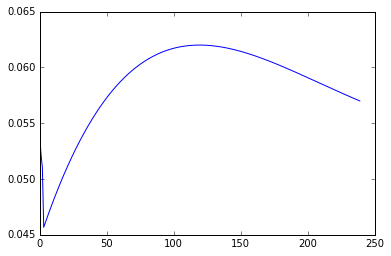

In [64]:
t_range = np.arange(1,241-3)/12
r0 = short_rate
#r0 = df_mthly_10_yr_LIBOR_04['Rate'][8]
libor_rate_arr = [df_mthly_10_yr_LIBOR_04['Rate'][i] for i in range(5,8)]
Z_arr = []
r_arr = []

for t in t_range:
    Z_10 = HW.Z(0, t+10, r0, kappa, sigma, coeff)
    Z_1 = HW.Z(0, t, r0, kappa, sigma, coeff)
    
    r_10 = HW.r_t(0, t+10, r0, kappa, sigma, coeff)
    r_1 = HW.r_t(0, t, r0, kappa, sigma, coeff)
    r_arr.append(HW.r_t(0, t+10, r0, kappa, sigma, coeff))
   
    # r(t1, t2) = (1/(t2 - t1)) * ( ln(DF(0,t1)) - ln(DF(0,t2)) )
    #libor_rate_arr.append((np.log(Z_1) - np.log(Z_10)) / (t+10 - t))
    libor_rate_arr.append((r_10*(t+10) - r_1*(t)) / (t+10 - t))
    
#plt.plot(libor_rate_arr[3:])
#plt.plot(r_arr)
plt.plot(libor_rate_arr)
#libor_rate_arr[:8]

#### Ouput results from matlab functions

In [43]:
gamma = 0.0568
p = 2.9025
beta_1 = -12.6051
beta_2 = -2.0992

#### Standard error results from matlab code

In [44]:
gamma_se = 0.0018
p_se = 0.0750
beta_1_se = 1.9998
beta_2_se = 0.0495

# Q1

#### hazard function

In [45]:
t_range_int = [int(t*12) for t in t_range]

sum_ind_arr = [1, 0, 0, 0, 0, 0, 0 , 0, 0, 1, 1, 1] * 20
beta_arr = np.array([beta_1, beta_2])

v_1_pool1 = WACs[0] - np.array(libor_rate_arr)
v_1_pool2 = WACs[1] - np.array(libor_rate_arr)

v_arr_1 = np.array([[v_x, v_y] for v_x, v_y in zip(v_1_pool1, sum_ind_arr)])
v_arr_2 = np.array([[v_x, v_y] for v_x, v_y in zip(v_1_pool2, sum_ind_arr)])

exp_val_1 = np.dot(v_arr_1, beta_arr)
exp_val_2 = np.dot(v_arr_2, beta_arr)

hazard_arr_1 = []
hazard_arr_2 = []


for i in range(len(t_range)):
    hazard_val_1 = ((gamma*p * (gamma * t_range[i])**(p-1)) / \
                  (1 + (gamma * t_range[i])**p)) * \
                  np.exp(exp_val_1[i])
    hazard_arr_1.append(hazard_val_1)

    hazard_val_2 = ((gamma*p * (gamma * t_range[i])**(p-1)) / \
                  (1 + (gamma * t_range[i])**p)) * \
                  np.exp(exp_val_2[i])
    hazard_arr_2.append(hazard_val_2)

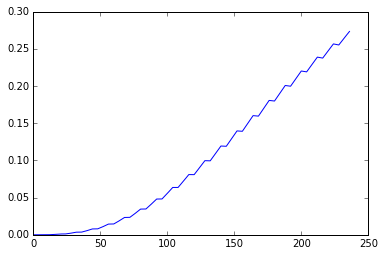

In [46]:
ave_hazard_arr_1 = np.cumsum(hazard_arr_1) / (t_range + 10)
ave_hazard_arr_2 = np.cumsum(hazard_arr_2) / (t_range + 10)
plt.plot(ave_hazard_arr_1)

# Qc

### Effective Duration

In [11]:
HW